<a href="https://colab.research.google.com/github/chrishg23-jpg/HES-benchmark/blob/main/EmergentRegulator005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

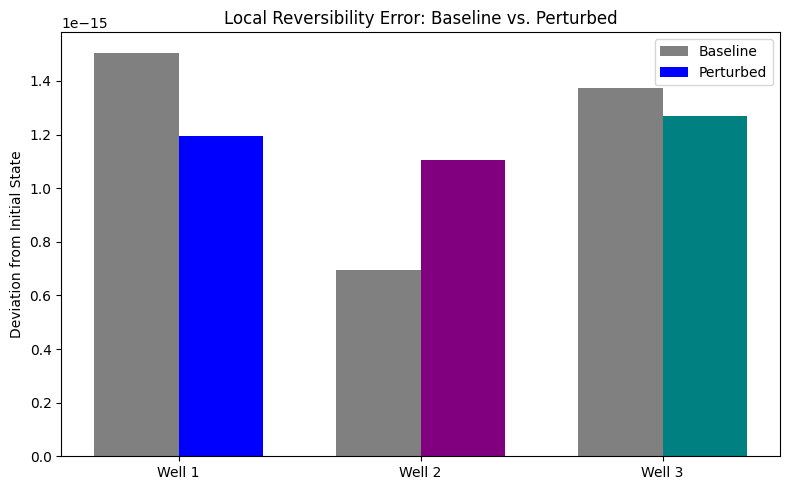

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 100
T = 50
x = np.linspace(0, 1, N)
v0 = np.sin(2 * np.pi * x)

# Multi-well curvature field
def multi_well_field(wells):
    field = np.zeros_like(x)
    for center, strength, width in wells:
        field += strength * np.exp(-((x - center)**2) / width)
    return field

# Evolution with optional perturbation
def evolve_forward(v_init, curvature, steps, perturb_region=None, perturb_strength=0.0):
    traj = [v_init.copy()]
    v = v_init.copy()
    noises = []
    for t in range(steps):
        noise = np.random.randn(N) * (1.0 / (1.0 + curvature))
        if perturb_region and t == steps // 2:
            start, end = perturb_region
            noise[start:end] += np.random.randn(end - start) * perturb_strength
        v += noise
        traj.append(v.copy())
        noises.append(noise)
    return np.array(traj), noises

# Reverse evolution
def evolve_reverse(v_final, curvature, noises):
    traj = [v_final.copy()]
    v = v_final.copy()
    for noise in reversed(noises):
        v -= noise
        traj.append(v.copy())
    return np.array(traj)

# Local deviation metric
def local_deviation(v_recovered, v_original, region):
    start, end = region
    return np.linalg.norm(v_recovered[start:end] - v_original[start:end])

# Define curvature wells
wells = [
    (0.25, 3.0, 0.01),
    (0.5, 5.0, 0.005),
    (0.75, 2.0, 0.02)
]
C = multi_well_field(wells)

# Define regions
regions = [
    (int(0.20 * N), int(0.30 * N)),  # Well 1
    (int(0.45 * N), int(0.55 * N)),  # Well 2
    (int(0.70 * N), int(0.80 * N))   # Well 3
]
labels = ["Well 1", "Well 2", "Well 3"]
colors = ["blue", "purple", "teal"]

# Perturbation zone (between wells)
perturb_region = (int(0.35 * N), int(0.40 * N))

# Run baseline
traj_base, noises_base = evolve_forward(v0, C, T)
reverse_base = evolve_reverse(traj_base[-1], C, noises_base)

# Run perturbed
traj_pert, noises_pert = evolve_forward(v0, C, T, perturb_region, perturb_strength=5.0)
reverse_pert = evolve_reverse(traj_pert[-1], C, noises_pert)

# Compute deviations
dev_base = [local_deviation(reverse_base[-1], v0, r) for r in regions]
dev_pert = [local_deviation(reverse_pert[-1], v0, r) for r in regions]

# Plot comparison
x_pos = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x_pos - width/2, dev_base, width, label='Baseline', color='gray')
plt.bar(x_pos + width/2, dev_pert, width, label='Perturbed', color=colors)
plt.xticks(x_pos, labels)
plt.ylabel("Deviation from Initial State")
plt.title("Local Reversibility Error: Baseline vs. Perturbed")
plt.legend()
plt.tight_layout()
plt.show()
